In [15]:
import zipfile
import os

In [31]:
#unzip the folder
zip_path = "/content/v3_validation.zip"
extract_path = "/content/v3unzip_validation1"  # target directory to extract

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted ZIP to: {extract_path}\n")

# Step 2: Walk through subfolders and count CSV files
csv_counts = {}

for root, dirs, files in os.walk(extract_path):
    csv_files = [file for file in files if file.endswith('.csv')]
    if csv_files:
        relative_path = os.path.relpath(root, extract_path)
        csv_counts[relative_path] = len(csv_files)


Extracted ZIP to: /content/v3unzip_validation1



In [32]:
# Walk through subfolders and count CSV files
csv_counts = {}

for root, dirs, files in os.walk(extract_path):
    csv_files = [file for file in files if file.endswith('.csv')]
    if csv_files:
        relative_path = os.path.relpath(root, extract_path)
        csv_counts[relative_path] = len(csv_files)

# Step 3: Print results
print("CSV file count by subfolder:\n")
for folder, count in csv_counts.items():
    print(f"{folder}: {count} CSV file(s)")

CSV file count by subfolder:

v3_validation/v3/test/with_hook_climbing_up: 3 CSV file(s)
v3_validation/v3/test/without_hook_climbing_up: 6 CSV file(s)
v3_validation/v3/test/idle: 3 CSV file(s)
v3_validation/v3/test/with_hook_descending_down: 3 CSV file(s)
v3_validation/v3/test/without_hook_descending_down: 6 CSV file(s)
v3_validation/v3/Validation/with_hook_climbing_up: 1 CSV file(s)
v3_validation/v3/Validation/without_hook_climbing_up: 1 CSV file(s)
v3_validation/v3/Validation/idle: 1 CSV file(s)
v3_validation/v3/Validation/with_hook_descending_down: 1 CSV file(s)
v3_validation/v3/Validation/without_hook_descending_down: 1 CSV file(s)
v3_validation/v3/train/with_hook_climbing_up: 16 CSV file(s)
v3_validation/v3/train/without_hook_climbing_up: 44 CSV file(s)
v3_validation/v3/train/idle: 21 CSV file(s)
v3_validation/v3/train/with_hook_descending_down: 19 CSV file(s)
v3_validation/v3/train/without_hook_descending_down: 44 CSV file(s)


In [33]:
import os
import numpy as np
import pandas as pd

def load_dataset_for_cnn(folder_path, max_timesteps=None):
    X = []
    y = []
    class_map = {}

    for class_index, class_name in enumerate(sorted(os.listdir(folder_path))):
        class_dir = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        class_map[class_index] = class_name

        for file in os.listdir(class_dir):
            if file.endswith(".csv"):
                file_path = os.path.join(class_dir, file)
                df = pd.read_csv(file_path)

                df = df.dropna(axis=1, how='any')  # Drop any columns with NaN

                X.append(df.values)
                y.append(class_index)

    if len(X) == 0:
        raise ValueError("No data loaded. Check if CSV files exist in the folder structure.")

    # Determine max timesteps if not provided
    if max_timesteps is None:
        max_timesteps = max([sample.shape[0] for sample in X])

    # Pad or truncate each sample to max_timesteps
    X_padded = []
    for sample in X:
        if sample.shape[0] < max_timesteps:
            pad_width = max_timesteps - sample.shape[0]
            padded = np.pad(sample, ((0, pad_width), (0, 0)), mode='constant')
        else:
            padded = sample[:max_timesteps, :]
        X_padded.append(padded)

    return np.stack(X_padded), np.array(y), class_map


In [35]:
train_path = "/content/v3unzip_validation1/v3_validation/v3/train"
test_path = "/content/v3unzip_validation1/v3_validation/v3/test"
validation_path = "/content/v3unzip_validation1/v3_validation/v3/Validation"

X_train, y_train, class_map = load_dataset_for_cnn(train_path)
X_test, y_test, _ = load_dataset_for_cnn(test_path)
X_validation, y_validation, _ = load_dataset_for_cnn(validation_path)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Validation shape:", X_validation.shape)


Train shape: (144, 1986, 12)
Test shape: (21, 650, 12)
Validation shape: (5, 807, 12)


In [36]:
MAX_TIMESTEPS = 1986

X_train, y_train, class_map = load_dataset_for_cnn(train_path, max_timesteps=MAX_TIMESTEPS)
X_test, y_test, _ = load_dataset_for_cnn(test_path, max_timesteps=MAX_TIMESTEPS)
X_validation, y_validation, _ = load_dataset_for_cnn(validation_path, max_timesteps=MAX_TIMESTEPS)


In [37]:
import numpy as np

def handle_nan(X):
    X_nan_handled = np.copy(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            feature_column = X[i, :, j]
            nan_mask = np.isnan(feature_column)
            if np.any(nan_mask):
                mean_val = np.nanmean(feature_column)
                feature_column[nan_mask] = mean_val
            X_nan_handled[i, :, j] = feature_column
    return X_nan_handled

X_train = handle_nan(X_train)
X_test = handle_nan(X_test)
X_validation = handle_nan(X_validation)

In [38]:
# Compute mean and std from training set only
mean = np.mean(X_train, axis=(0, 1), keepdims=True)
std = np.std(X_train, axis=(0, 1), keepdims=True)
X_train = (X_train - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)
X_validation = (X_validation - mean) / (std + 1e-8)

In [39]:
def extract_features(X):
    mean_feat = np.mean(X, axis=1)
    std_feat = np.std(X, axis=1)
    max_feat = np.max(X, axis=1)
    min_feat = np.min(X, axis=1)
    return np.concatenate([mean_feat, std_feat, max_feat, min_feat], axis=1)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Extract statistical features
X_train_feat = extract_features(X_train)
X_test_feat = extract_features(X_test)
X_validation_feat = extract_features(X_validation)

# Normalize
scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
X_test_feat_scaled = scaler.transform(X_test_feat)
X_validation_feat_scaled = scaler.transform(X_validation_feat)

# Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feat_scaled, y_train)
importances = rf.feature_importances_

# Select top-k features
top_k = 20
indices = np.argsort(importances)[-top_k:]

X_train_selected = X_train_feat_scaled[:, indices]
X_test_selected = X_test_feat_scaled[:, indices]
X_validation_selected = X_validation_feat_scaled[:, indices]


**add the selected features as extra channels to each time-series sample**

In [41]:
def append_features_to_sequence(X_seq, X_features):
    X_features_expanded = np.repeat(X_features[:, np.newaxis, :], X_seq.shape[1], axis=1)
    return np.concatenate((X_seq, X_features_expanded), axis=2)

# Apply to all datasets
X_train_fused = append_features_to_sequence(X_train, X_train_selected)
X_test_fused = append_features_to_sequence(X_test, X_test_selected)
X_validation_fused = append_features_to_sequence(X_validation, X_validation_selected)

print("New CNN input shape (Train):", X_train_fused.shape)
print("New CNN input shape (Test):", X_test_fused.shape)
print("New CNN input shape (Validation):", X_validation_fused.shape)


New CNN input shape (Train): (144, 1986, 32)
New CNN input shape (Test): (21, 1986, 32)
New CNN input shape (Validation): (5, 1986, 32)


In [42]:
print("Train set shape:", X_train_fused.shape, y_train.shape)
print("Test set shape:", X_test_fused.shape, y_test.shape)
print("Validation set shape:", X_validation_fused.shape, y_validation.shape)

Train set shape: (144, 1986, 32) (144,)
Test set shape: (21, 1986, 32) (21,)
Validation set shape: (5, 1986, 32) (5,)


In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)
y_validation_cat = tf.keras.utils.to_categorical(y_validation, num_classes)

input_shape = X_train_fused.shape[1:]

#Cnn model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(np.unique(y_train)), activation='softmax')  # Number of classes
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_fused, y_train_cat,
                    epochs=50,
                    batch_size=32,
                    validation_data= (X_validation_fused, y_validation_cat),
                    callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1982, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1982, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 991, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 991, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 989, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 989, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 494, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 494, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 63232)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,093,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,130,245 (31.01 MB)

 Trainable params: 8,129,861 (31.01 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 477ms/step - accuracy: 0.4770 - loss: 5.5380 - val_accuracy: 0.6000 - val_loss: 2.1183
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8440 - loss: 3.6092 - val_accuracy: 0.8000 - val_loss: 0.9196
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.9265 - loss: 1.1636 - val_accuracy: 1.0000 - val_loss: 0.0222
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.9664 - loss: 0.4238 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - accuracy: 0.9805 - loss: 0.0920 - val_accuracy: 1.0000 - val_loss: 9.6911e-04
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.9646 - loss: 0.3440 - val_accuracy: 1.0000 - val_loss: 8.3445e-06
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.9905 - loss: 0.5148 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.9751 - loss: 0.3179 - val_accuracy: 1.0000 - 

In [44]:
test_loss, test_acc = model.evaluate(X_test_fused, y_test_cat)
print(f"\nTest Accuracy: {test_acc:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9048 - loss: 0.6974

Test Accuracy: 90.48%


**Predict and Generate Classification Report**

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test data
y_pred_probs = model.predict(X_test_fused)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[class_map[i] for i in sorted(class_map)]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Classification Report:

                              precision    recall  f1-score   support

                        idle       0.75      1.00      0.86         3
       with_hook_climbing_up       1.00      1.00      1.00         3
   with_hook_descending_down       1.00      1.00      1.00         3
    without_hook_climbing_up       1.00      0.67      0.80         6
without_hook_descending_down       0.86      1.00      0.92         6

                    accuracy                           0.90        21
                   macro avg       0.92      0.93      0.92        21
                weighted avg       0.92      0.90      0.90        21



**Plot confusion matrixt**

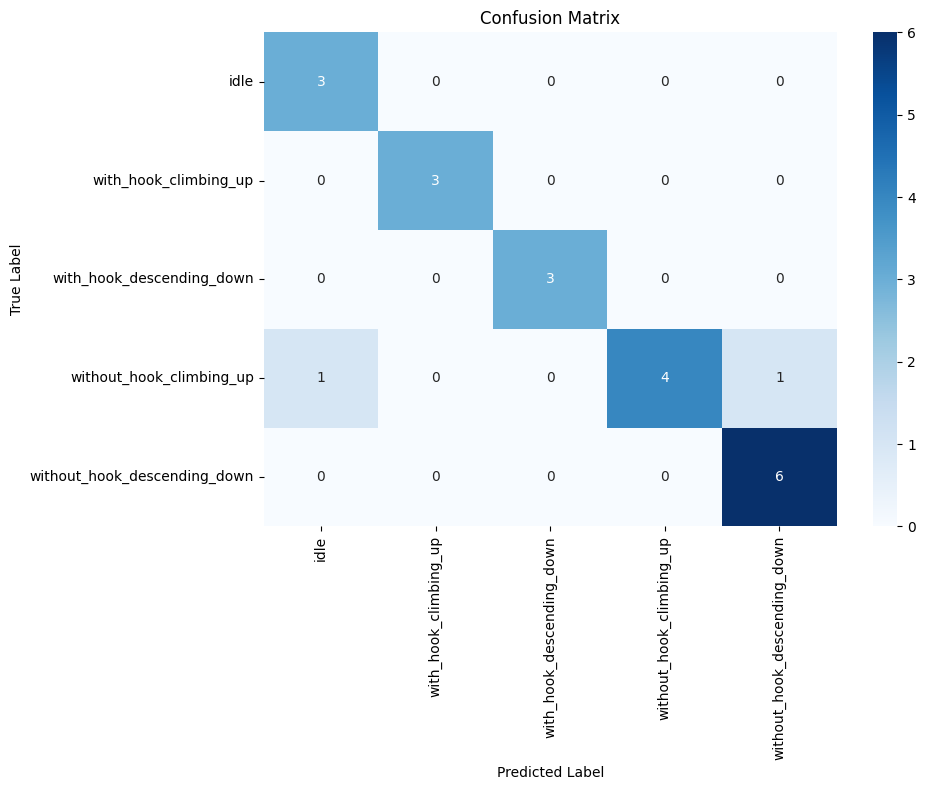

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_map[i] for i in sorted(class_map)],
            yticklabels=[class_map[i] for i in sorted(class_map)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [48]:
model.save("fall_detection_model.h5")
